In [1]:
import numpy as np
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
from astropy.io import fits
from astropy import units as u
from astropy.visualization import simple_norm
import aplpy
from matplotlib.pyplot import figure
from astropy.wcs import WCS
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import mad_std, sigma_clipped_stats
#astropy.nddata.utils
from astropy import wcs
from tqdm import tqdm
from astropy.table import Table, QTable
from tabulate import tabulate

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, SkyCircularAperture, ApertureStats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.background import Background2D, interpolators
from photutils.utils import calc_total_error
from scipy import ndimage

from scipy import stats
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec

In [4]:
# Reading the first 70 columns of data
col_names_big = [f"col{i}" for i in range(1, 71)]
chunksize = 100_000_000
reader_big = pd.read_csv(
    "wlm_f150.phot",      # path to your 8 GB ASCII file
    sep=r"\s+",            # adjust to your delimiter
    header=None,           # file has no header row
    names=col_names_big,       # assign these names to columns 0–69
    usecols=range(70),     # only read the first 70 columns
    chunksize=chunksize,   # stream 200k rows at a time
    comment="#",           # if you have comment-lines
    engine="c"             # fastest parsing engine
)
dfs_big = []
for chunk_big in reader_big:
    dfs_big.append(chunk_big)
table_big = pd.concat(dfs_big, ignore_index=True)


In [5]:
table_big

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70
0,1,1,5675.50,107.25,0.00,1293.7,-1.725,0.155,175,0.000,...,0.000,0.000,0.000,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
1,1,1,4283.87,699.50,0.00,2068.6,6.566,0.076,120,0.000,...,0.000,0.000,0.000,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
2,1,1,8352.64,3787.49,0.00,1441.1,-7.315,0.280,0,0.354,...,0.000,0.000,0.000,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
3,1,1,8354.90,3784.75,0.00,1612.0,-5.994,0.558,90,0.590,...,0.000,0.000,0.000,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
4,1,1,5607.88,1200.50,0.00,619.8,2.850,0.054,50,0.458,...,0.000,0.000,0.000,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184399,1,1,132.45,3136.30,0.99,5.7,-0.014,9.999,5,1.553,...,-0.000,9.999,2.930,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
2184400,1,1,489.02,2745.22,1.18,5.3,0.049,9.999,105,0.271,...,-0.456,0.193,0.602,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
2184401,1,1,6704.05,3755.09,1.38,6.3,-0.005,9.999,160,0.265,...,0.180,-0.473,1.649,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999
2184402,1,1,165.85,3254.69,1.27,6.0,-0.106,9.999,25,0.589,...,0.013,-8.165,0.757,0,0.0,0.0,0.0,3.510000e-07,99.999,99.999


# Diagnostic Plots of the big photometric catalog

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


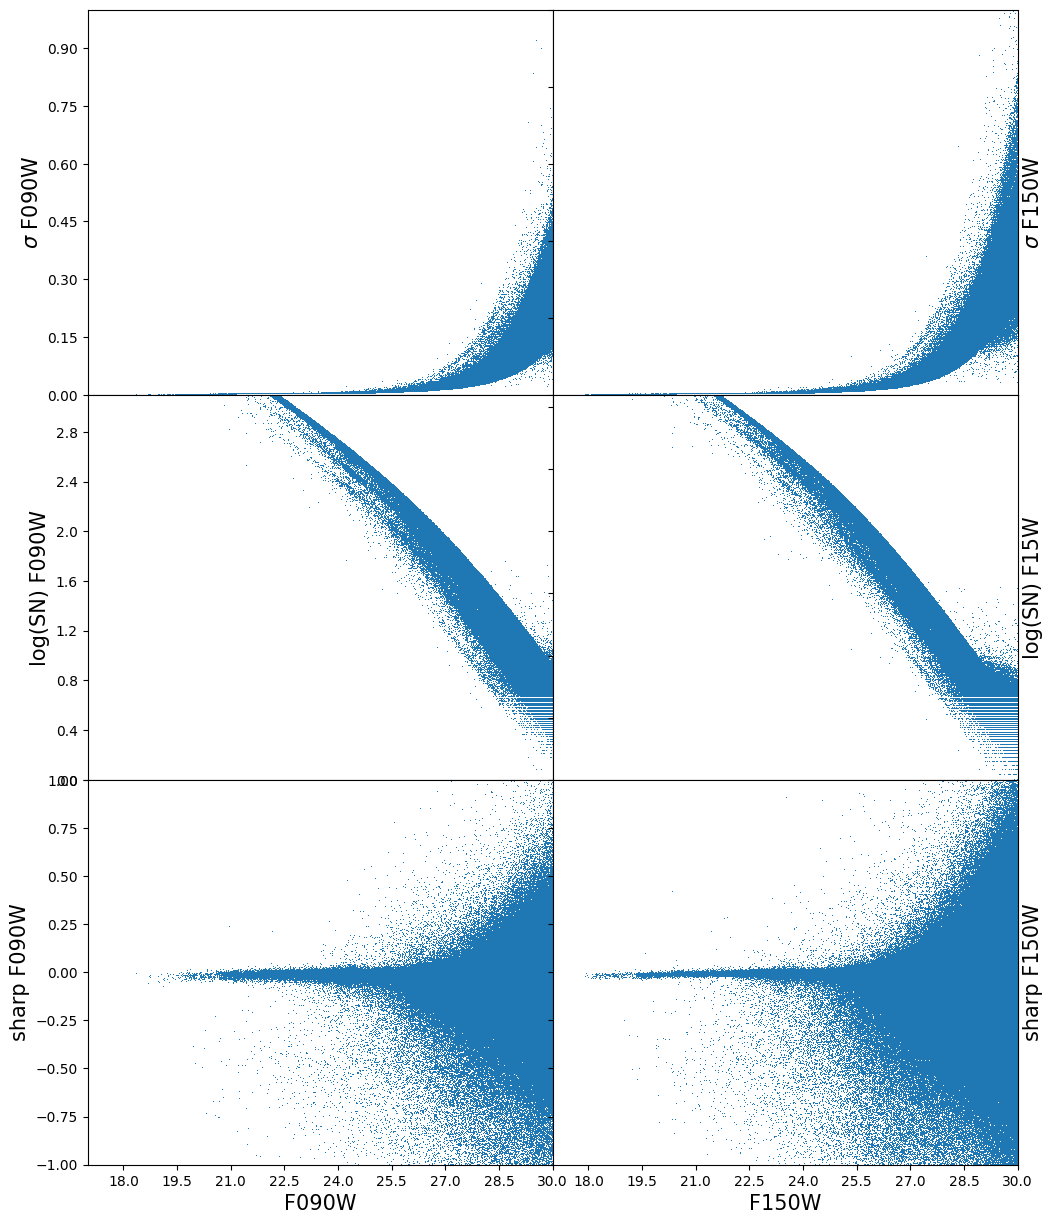

In [6]:
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

fig, ax1 = plt.subplots(3, 2, figsize=(12, 15), sharex = True)

ax1[0,0].plot(np.array(table_big['col17']), np.array(table_big['col19']),',')
ax1[0,0].set_xlim([17,30])
ax1[0,0].set_ylim([0,1])
ax1[0,0].set_ylabel('$\sigma$ F090W',fontsize=15)
ax1[0,1].plot(np.array(table_big['col30']), np.array(table_big['col32']),',')
ax1[0,1].set_xlim([17,30])
ax1[0,1].set_ylim([0,1])
ax1[0,1].set_yticklabels([])
ax1[0,1].set_ylabel('$\sigma$ F150W',fontsize=15)
ax1[0,1].yaxis.set_label_position("right")
ax1[1,0].plot(np.array(table_big['col17']), np.log10(table_big['col21']),',')
ax1[1,0].set_xlim([17,30])
ax1[1,0].set_ylim([0,3.1])
ax1[1,0].set_ylabel('log(SN) F090W',fontsize=15)
ax1[1,1].plot(np.array(table_big['col30']), np.log10(table_big['col34']),',')
ax1[1,1].set_xlim([17,30])
ax1[1,1].set_ylim([0,3.1])
ax1[1,1].set_yticklabels([])
ax1[1,1].set_ylabel('log(SN) F15W',fontsize=15)
ax1[1,1].yaxis.set_label_position("right")
ax1[2,0].plot(np.array(table_big['col17']), np.array(table_big['col22']),',')
ax1[2,0].set_xlim([17,30])
ax1[2,0].set_ylim([-1,1])
ax1[2,0].set_xlabel('F090W',fontsize=15)
ax1[2,0].set_ylabel('sharp F090W',fontsize=15)
ax1[2,1].plot(np.array(table_big['col30']), np.array(table_big['col35']),',')
ax1[2,1].set_xlim([17,30])
ax1[2,1].set_ylim([-1,1])
ax1[2,1].set_yticklabels([])
ax1[2,1].set_ylabel('sharp F150W',fontsize=15)
ax1[2,1].yaxis.set_label_position("right")
ax1[2,1].set_xlabel('F150W',fontsize=15)

nbins = len(ax1[2,0].get_xticklabels())
#plt.tight_layout()
plt.subplots_adjust(hspace=.0,wspace=.0)
ax1[0,0].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))
#ax1[0,0].set_ylabel(ylabel)
ax1[1,0].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))
#ax1[1,0].set_ylabel(ylabel)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


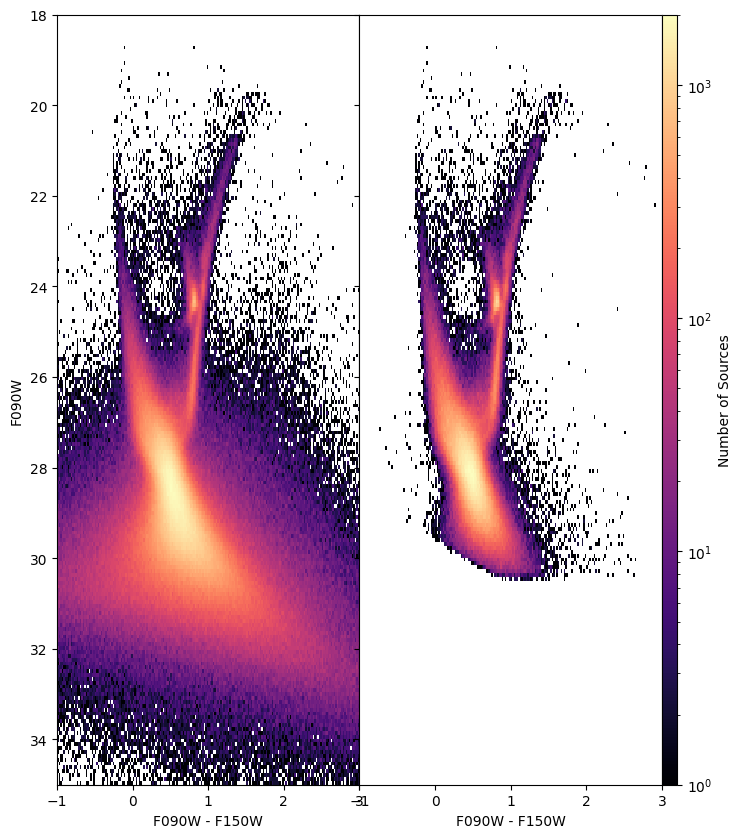

In [28]:
# Prepare data
color = np.array(table_big['col17']) - np.array(table_big['col30'])
mag = np.array(table_big['col17'])

ind_culling = (
    (table_big['col21'] >= 5) & 
    (table_big['col34'] >= 5) & 
    (table_big['col22']**2 <= 0.01) & 
    (table_big['col35']**2 <= 0.01) & 
    (table_big['col24'] <= 0.5) & 
    (table_big['col37'] <= 0.5) &
    (table_big['col25'] <= 3) & 
    (table_big['col38'] <= 3) &
    (table_big['col11'] <= 2)
)

color_culling = np.array(table_big['col17'])[ind_culling] - np.array(table_big['col30'])[ind_culling]
mag_culling = np.array(table_big['col17'])[ind_culling]

# Plot
fig = plt.figure(figsize=(8, 10), constrained_layout=True)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0)

# Panel 1: Full sample
ax0 = fig.add_subplot(gs[0])
h0 = ax0.hist2d(color, mag, bins=200, range=[[-1, 3], [18, 35]],
                cmap='magma', norm=LogNorm())
ax0.invert_yaxis()
ax0.set_xlim(-1, 3)
ax0.set_ylim(35, 18)
ax0.set_xlabel('F090W - F150W')
ax0.set_ylabel('F090W')

# Panel 2: Culled sample
ax1 = fig.add_subplot(gs[1], sharey=ax0)
h1 = ax1.hist2d(color_culling, mag_culling, bins=200, range=[[-1, 3], [18, 35]],
                cmap='magma', norm=LogNorm())
ax1.invert_yaxis()
ax1.set_xlim(-1, 3)
ax1.set_xlabel('F090W - F150W')
plt.setp(ax1.get_yticklabels(), visible=False)

# Shared colorbar
cax = plt.subplot(gs[2])
cb = plt.colorbar(h0[3], cax=cax)
cb.set_label('Number of Sources')

plt.show()

# Data Tables for each dither in each frame

In [14]:
from astropy.io import ascii
reader_f090_1 = ascii.read('wlm_f090_1.phot')
reader_f090_2 = ascii.read('wlm_f090_2.phot')
reader_f090_3 = ascii.read('wlm_f090_3.phot')
reader_f090_4 = ascii.read('wlm_f090_4.phot')

In [19]:
reader_f430_1 = ascii.read('wlm_f430_1.phot')
reader_f430_2 = ascii.read('wlm_f430_2.phot')
reader_f430_3 = ascii.read('wlm_f430_3.phot')
reader_f430_4 = ascii.read('wlm_f430_4.phot')

In [26]:
reader_f250_1 = ascii.read('wlm_f250_1.phot')
reader_f250_2 = ascii.read('wlm_f250_2.phot')
reader_f250_3 = ascii.read('wlm_f250_3.phot')
reader_f250_4 = ascii.read('wlm_f250_4.phot')

In [29]:
reader_f150_1 = ascii.read('wlm_f150_1.phot')
reader_f150_2 = ascii.read('wlm_f150_2.phot')
reader_f150_3 = ascii.read('wlm_f150_3.phot')
reader_f150_4 = ascii.read('wlm_f150_4.phot')